# 組み合わせバンディッド： バンディッドアルゴリズムと統計モデルの出会い

デザイン案をダミー変数を使ってベクトルで表現

$$
\boldsymbol{x}_A=\left(\begin{array}{cc} 0 \\ 0 \end{array}\right)
,
\boldsymbol{x}_B=\left(\begin{array}{cc} 0 \\ 1 \end{array}\right)
,
\boldsymbol{x}_C=\left(\begin{array}{cc} 1 \\ 0 \end{array}\right)
,
\boldsymbol{x}_D=\left(\begin{array}{cc} 1 \\ 1 \end{array}\right)
$$

上記ベクトルは一つずつ固有のクリック率$\theta_x$を持っているとする
クリック率をパラメータに持つベルヌーイ分布からクリック（報酬）が生成される

$$
r \sim p(r|\theta_x) = Bernoulli(\theta_x)
$$

# 6.2 線形モデルと一般化線形モデル
各要素$x_1, x_2$とクリック率$\theta$の間にモデルを構築

$$
\theta_x = \alpha + \beta_1 x_1 + \beta_2 x_2  \\
\theta_x = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2) \\
\theta_x = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2 + \gamma x_1 x_2) \\
$$

上記モデルをベクトルの内積で書き直す

$$
\theta_x = \Phi(\boldsymbol{x})^{\mathrm{T}}\boldsymbol{w},　\Phi(x) = (x_1, x_2, 1)^{\mathrm{T}}\boldsymbol{w}, 　\boldsymbol{w}=(\beta_1, \beta_2, \alpha) \\
\theta_x = logistic(\Phi(\boldsymbol{x})^{\mathrm{T}}\boldsymbol{w},　\Phi(x) = (x_1, x_2, 1)^{\mathrm{T}},　\boldsymbol{w} = (\beta_1, \beta_2, \alpha)^{\mathrm{T}}  \\
\theta_x = logistic(\Phi(\boldsymbol{x})^{\mathrm{T}}\boldsymbol{w},　\Phi(x) = (x_1 x_2, x_1, x_2, 1)^{\mathrm{T}},　\boldsymbol{w} = (\gamma, \beta_1, \beta_2, \alpha)^{\mathrm{T}}
$$

$\Phi(\boldsymbol{x})^{\mathrm{T}}\boldsymbol{w}$を線形モデル  
線形モデルを何らか関数で包んだモデル => 一般化線形モデル => 今回はロジスティック回帰モデル  
  
ロジスティック回帰モデルはロジット関数で以下のように書き直せる
$$
logit(\theta_x) = \Phi(\boldsymbol{x})^{\mathrm{T}}\boldsymbol{w}
$$

# 6.3 MCMCをバンディッドにつかう

文脈（組み合わせ）を考慮するとバンディッドモデルは組み合わせ爆発が起きて、テーブルの行数が爆発  
解自体が持つ特徴を反映できない  
=> モデルベースのアプローチが必要となる

In [13]:
import numpy as np
import pymc3 as pm

In [26]:
# P107と見比べてよく考える
arms = [[0, 0], [0, 1], [1, 0], [1, 1]]

class MCMC_GLMTSAgent(object):
  # 選択可能な解の集合X(t)を表すarmsを定義する
  # Φ(x)=(x_1, x_2, 1)^T を特徴量としている
  def __init__(self):
    self.counts = [0 for _ in arms]
    self.wins = [0 for _ in arms]
    self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T

  # MCMCを実行
  # 各解の報酬の期待値θを推論
  def get_arm(self):
    if 0 in self.counts: return self.counts.index(0)
    with pm.Model() as model:
      w = pm.Normal('w', mu=0, sigma=10, shape=3)
      # 線形予測子に相当するlinpredを求める
      # β_1x_1 + β_2x_2 + αを作っている？
      linpred = pm.math.dot(w, self.phis)
      # 線形予測子にロジスティック関数をかけて、確率変数θを決定
      theta = pm.Deterministic(
          'theta', 1 / (1 + pm.math.exp(-linpred)))
      obs = pm.Binomial(
          'obs', n=self.counts, p=theta, observed=self.wins)
      trace = pm.sample(2000, chains=1)
    # 事後分布から各解の報酬期待値thetaを一つだけサンプリング
    sample = pm.sample_posterior_predictive(
        trace, samples=1, model=model, vars=[theta])
    # サンプルの値が最大となる解のインデックスを返す
    return np.argmax(sample['theta'])

  def sample(self, arm_index, reward):
    self.counts[arm_index] += 1
    self.wins[arm_index] += reward

In [15]:
# エージェントが対峙する環境を用意する
# theta_x = logistic(0.2x_1 + 0.8x_2 -4)を持つベルヌーイ分布に従って報酬が与えられる
class Env(object):
  def p(arm):
    x = arm[0] * 0.2 + arm[1] * 0.8 - 4
    p = 1 / (1 + np.exp(-x))
    return p

  def react(arm):
    return 1 if np.random.random() < Env.p(arm) else 0

  def opt():
    return np.argmax([Env.p(arm) for arm in arms])

In [16]:
selected_arms = []
earned_rewards = []
n_step = 20
agent = MCMC_GLMTSAgent()
for step in range(n_step):
  arm_index = agent.get_arm()
  # 選択肢の更新を50回に一回とする
  for _ in range(50):
    reward = Env.react(arms[arm_index])
    agent.sample(arm_index, reward)
    selected_arms.append(arm_index)
    earned_rewards.append(reward)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


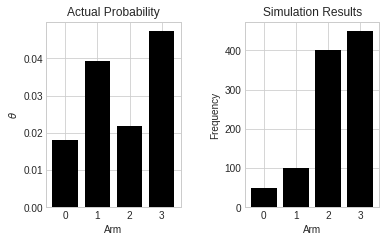

In [17]:
from collections import Counter
from matplotlib import pyplot as plt

arm_count = [row[1] for row in sorted(Counter(selected_arms).items())]
plt.subplot(1, 2, 1)
plt.bar(range(4), [Env.p(arm) for arm in arms], tick_label=range(4))
plt.xlabel('Arm')
plt.ylabel(r'$\theta$')
plt.title('Actual Probability')
plt.subplot(1, 2, 2)
plt.bar(range(4), arm_count, tick_label=range(4))
plt.xlabel('Arm')
plt.ylabel('Frequency')
plt.title('Simulation Results')
plt.tight_layout(pad=3)
plt.show()

上のロジックの計算には時間がかかるから、別のやり方をしようね

# ベイズ線形回帰モデル

$$
\boldsymbol{w} \sim p(\boldsymbol{w}) = N(\boldsymbol{\mu , \Sigma}) \\ 
\theta = \Phi(\boldsymbol{x})^{\mathrm{T}}\boldsymbol{w} \\
r \sim p(r|\theta, \sigma^2) = N(\theta, \sigma^2)
$$

期待値$\theta$がパラメータと特徴量の内積のみで表される => 線形回帰モデル

# LinUCBアルゴリズム

LinerUCBだからLinUCB？

In [18]:
class LinUCBAgent(object):
  def __init__(self):
    self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
    self.alpha = 1
    self.sigma = 1
    self.A = np.identity(self.phis.shape[0])
    self.b = np.zeros((self.phis.shape[0], 1))

  def get_arm(self):
    inv_A = np.linalg.inv(self.A)
    mu = inv_A.dot(self.b)
    S = inv_A
    pred_mean = self.phis.T.dot(mu)
    pred_var = self.phis.T.dot(S).dot(self.phis)
    ucb = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
    return np.argmax(ucb)

  def sample(self, arm_index, reward):
    phi = self.phis[:, [arm_index]]
    self.b = self.b + phi * reward / (self.sigma ** 2)
    self.A = self.A + phi.dot(phi.T) / (self.sigma ** 2)

最適解を選択する正解率の推移を見てみる

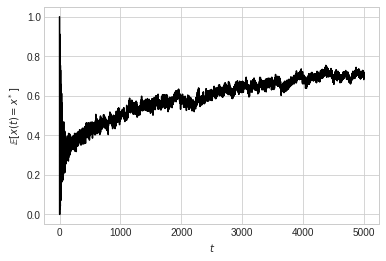

In [23]:
n_iter = 500
n_step = 5000
selected_arms = np.zeros((n_iter, n_step), dtype=int)
earned_rewards = np.zeros((n_iter, n_step), dtype=int)
for it in range(n_iter):
  agent = LinUCBAgent()
  for step in range(n_step):
    arm_index = agent.get_arm()
    reward = Env.react(arms[arm_index])
    agent.sample(arm_index, reward)
    selected_arms[it, step] = arm_index
    earned_rewards[it, step] = reward
plt.plot(np.mean(selected_arms==Env.opt(), axis=0))
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.show()

## 逆行列の計算を回避することによる高速化

In [20]:
class LinUCBAgent2(object):
  def __init__(self):
    self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
    self.alpha = 1
    self.sigma = 1
    self.inv_A = np.identity(self.phis.shape[0])
    self.b = np.zeros((self.phis.shape[0], 1))

  def get_arm(self):
    post_mean = self.inv_A.dot(self.b)
    post_var = self.inv_A
    pred_mean = self.phis.T.dot(post_mean)
    pred_var = self.phis.T.dot(post_var).dot(self.phis)
    ucb = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
    return np.argmax(ucb)

  def sample(self, arm_index, reward):
    phi = self.phis[:, [arm_index]]
    iAppTiA = self.inv_A.dot(phi).dot(phi.T).dot(self.inv_A)
    s2_pTiAp = self.sigma ** 2 + phi.T.dot(self.inv_A).dot(phi)
    self.inv_A = self.inv_A - iAppTiA / s2_pTiAp
    self.b = self.b + (self.sigma ** 2) * reward * phi

In [21]:
# 5章からコピー
class UCBAgent(object):

  def __init__(self):
    self.count = [0 for _ in range(n_arms)]
    self.value = [0 for _ in range(n_arms)]

  def calc_ucb(self, arm):
    ucb = self.value[arm]
    ucb += np.sqrt(np.log(sum(self.count)) / (2 * self.count[arm]))
    return ucb

  def get_arm(self):
    if 0 in self.count:
      arm = self.count.index(0)
    else:
      ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
      arm = ucb.index(max(ucb))
    return arm

  def sample(self, arm, reward):
    self.count[arm] = self.count[arm] + 1
    self.value[arm] = (
        (self.count[arm] - 1) * self.value[arm] + reward
        ) / self.count[arm]

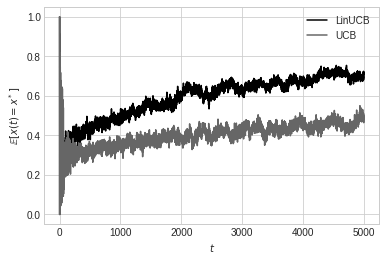

In [22]:
agent_classes = [LinUCBAgent2, UCBAgent]
n_arms = len(arms)
n_iter = 500
n_step = 5000
selected_arms = np.zeros(
    (n_iter, len(agent_classes), n_step), dtype=int)
earned_rewards = np.zeros(
    (n_iter, len(agent_classes), n_step), dtype=int)
for it in range(n_iter):
  for i, agent_class in enumerate(agent_classes):
    agent = agent_class()
    for step in range(n_step):
      arm_index = agent.get_arm()
      arm = arms[arm_index]
      reward = Env.react(arm)
      agent.sample(arm_index, reward)
      selected_arms[it, i, step] = arm_index
      earned_rewards[it, i, step] = reward

acc = np.mean(selected_arms==Env.opt(), axis=0)
plt.plot(acc[0], label='LinUCB')
plt.plot(acc[1], label='UCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()